In [20]:
import jax
from flax import nnx

In [21]:
# Import additional libraries for data loading and training
from datasets import load_dataset, Dataset
import numpy as np
import optax
from tqdm import tqdm
from typing import Optional, Callable

In [22]:
jax.devices()

[CudaDevice(id=0)]

In [23]:
data_dir = "./data"
# Load CIFAR-10 dataset
dataset = load_dataset("uoft-cs/cifar10", cache_dir=data_dir)
dataset = dataset.with_format("jax")
train_data = dataset["train"]
test_data = dataset["test"]
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

print(train_data.features)

print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f"Sample shape: {train_data[0]['img'].shape}")

data_dim = train_data[0]["img"].shape[0] * train_data[0]["img"].shape[1] * train_data[0]["img"].shape[2]


{'img': Image(mode=None, decode=True), 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}
Train samples: 50000
Test samples: 10000
Sample shape: (32, 32, 3)


In [24]:
# Training configuration
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
NUM_EPOCHS = 100
SAVE_EVERY_N_EPOCHS = 1

In [25]:
from typing import TypedDict
import grain.python as grain
import jax.numpy as jnp


seed = 12
val_batch_size = 2 * BATCH_SIZE


def preprocess(image: jnp.ndarray, *, rng: Optional[np.random.Generator] = None) -> jnp.ndarray:
    # Convert to float32 and normalize to [0, 1]
    image = jnp.array(image, dtype=jnp.float32) / 255.0
    # Flatten the image
    return image
    
assert isinstance(train_data, Dataset)
assert isinstance(test_data, Dataset)

train_grain_dataset = grain.MapDataset.source(train_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng = rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=BATCH_SIZE)

test_grain_dataset = grain.MapDataset.source(test_data) \
    .random_map(lambda x, rng: preprocess(x["img"], rng = rng), seed=42) \
    .shuffle(seed=45) \
    .batch(batch_size=val_batch_size)

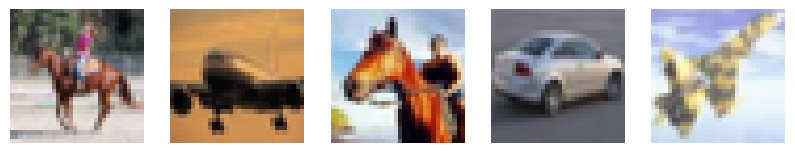

In [26]:
# Display 5 samples from the training dataset
import matplotlib.pyplot as plt

example_batch = next(iter(train_grain_dataset))
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(example_batch[i].reshape(32, 32, 3))
    axes[i].axis('off')
plt.show()

In [27]:
from typing import Literal


def get_norm_layer(norm_type: Literal["BN", "LN", "GN"], num_features: int, rngs: nnx.Rngs) -> Callable[[jax.Array], jax.Array]:
    """Normalization layer."""
    if norm_type == 'BN':
        raise NotImplementedError
    elif norm_type == 'LN':
        norm_fn = nnx.LayerNorm(num_features=num_features, rngs=rngs)
    elif norm_type == 'GN':
        norm_fn = nnx.GroupNorm(num_features=num_features, rngs=rngs)
    else:
        raise NotImplementedError
    return norm_fn


def tensorflow_style_avg_pooling(x: jax.Array, window_shape: tuple[int, int], strides: tuple[int, int], padding: str) -> jax.Array:
    pool_sum = jax.lax.reduce_window(x, 0.0, jax.lax.add,
                                   (1,) + window_shape + (1,),
                                   (1,) + strides + (1,), padding)
    pool_denom = jax.lax.reduce_window(
        jnp.ones_like(x), 0.0, jax.lax.add, (1,) + window_shape + (1,),
        (1,) + strides + (1,), padding)
    return pool_sum / pool_denom

def upsample_2d(x: jax.Array, factor: int = 2) -> jax.Array:
    n, h, w, c = x.shape
    x = jax.image.resize(x, (n, h * factor, w * factor, c), method='nearest')
    return x

def downsample_2d(x: jax.Array) -> jax.Array:
    return tensorflow_style_avg_pooling(x, (2, 2), strides=(2, 2), padding='same')

def squared_euclidean_distance(a: jnp.ndarray,
                               b: jnp.ndarray,
                               b2: Optional[jnp.ndarray] = None) -> jnp.ndarray:
    """Computes the pairwise squared Euclidean distance.

    Args:
        a: float32: (n, d): An array of points.
        b: float32: (m, d): An array of points.
        b2: float32: (d, m): b square transpose.

    Returns:
        d: float32: (n, m): Where d[i, j] is the squared Euclidean distance between
        a[i] and b[j].
    """
    if b2 is None:
        b2 = jnp.sum(b.T**2, axis=0, keepdims=True)
    a2 = jnp.sum(a**2, axis=1, keepdims=True)
    ab = jnp.matmul(a, b.T)
    d = a2 - 2 * ab + b2
    return d

def entropy_loss_fn(affinity: jax.Array, loss_type: Literal["softmax", "argmax"] = "softmax", temperature: float = 1.0):
    """Calculates the entropy loss. Affinity is the similarity/distance matrix."""
    flat_affinity = affinity.reshape(-1, affinity.shape[-1])
    flat_affinity /= temperature
    probs = jax.nn.softmax(flat_affinity, axis=-1)
    log_probs = jax.nn.log_softmax(flat_affinity + 1e-5, axis=-1)
    if loss_type == "softmax":
        target_probs = probs
    elif loss_type == "argmax":
        codes = jnp.argmax(flat_affinity, axis=-1)
        onehots = jax.nn.one_hot(
            codes, flat_affinity.shape[-1], dtype=flat_affinity.dtype)
        onehots = probs - jax.lax.stop_gradient(probs - onehots)
        target_probs = onehots
    else:
        raise ValueError("Entropy loss {} not supported".format(loss_type))
    avg_probs = jnp.mean(target_probs, axis=0)
    avg_entropy = -jnp.sum(avg_probs * jnp.log(avg_probs + 1e-5))
    sample_entropy = -jnp.mean(jnp.sum(target_probs * log_probs, axis=-1))
    loss = sample_entropy - avg_entropy
    return loss

def sg(x: jax.Array) -> jax.Array:
    return jax.lax.stop_gradient(x)


In [28]:
class ResBlock(nnx.Module):
    """Basic Residual Block."""
    norm_1: Callable[[jax.Array], jax.Array]
    activation_fn1: Callable[[jax.Array], jax.Array]
    conv_1: nnx.Conv
    norm_2: Callable[[jax.Array], jax.Array]
    activation_fn2: Callable[[jax.Array], jax.Array]
    conv_2: nnx.Conv
    residual_conv: nnx.Conv
    in_features: int
    out_features: int

    
    def __init__(self, in_features: int, out_features: int, norm_type: Literal['BN', 'LN', 'GN'], activation_fn: Callable[[jax.Array], jax.Array], rngs: nnx.Rngs):
        self.in_features = in_features
        self.out_features = out_features
        self.norm_1 = get_norm_layer(norm_type, in_features, rngs)
        self.activation_fn1 = activation_fn
        self.conv_1 = nnx.Conv(in_features, kernel_size=(3, 3), use_bias=False, out_features=out_features, rngs=rngs)
        self.norm_2 = get_norm_layer(norm_type, out_features, rngs)
        self.activation_fn2 = activation_fn
        self.conv_2 = nnx.Conv(out_features, kernel_size=(3, 3), use_bias=False, out_features=out_features, rngs=rngs)
        self.residual_conv = nnx.Conv(in_features, kernel_size=(1, 1), use_bias=False, out_features=out_features, rngs=rngs)

    def __call__(self, x: jax.Array) -> jax.Array:
        input_dim = x.shape[-1]
        residual = x
        x= self.norm_1(x)
        x= self.activation_fn1(x)
        x= self.conv_1(x)
        x= self.norm_2(x)
        x= self.activation_fn2(x)
        x= self.conv_2(x)

        if input_dim != x.shape[-1]:
            residual = self.residual_conv(residual)
        
        return x + residual
    
def multi_resblock(num_blocks: int, in_features: int, out_features: int, norm_type: Literal['BN', 'LN', 'GN'], activation_fn: Callable[[jax.Array], jax.Array], rngs: nnx.Rngs) -> nnx.Sequential:
    return nnx.Sequential(*[
        ResBlock(
            in_features=in_features if i == 0 else out_features,
            out_features=out_features,
            norm_type=norm_type,
            activation_fn=activation_fn,
            rngs=rngs)
        for i in range(num_blocks)
    ])

class Encoder(nnx.Module):
    """From [H,W,D] image to [H',W',D'] embedding. Using Conv layers."""

    norm_layer: Callable[[jax.Array], jax.Array]
    initial_conv: nnx.Conv
    activation_fn: Callable[[jax.Array], jax.Array]
    blocks: nnx.Sequential
    final_res_blocks: nnx.Sequential
    last_conv: nnx.Conv

    def __init__(self, filters: int, num_res_blocks: int, channel_multipliers: list[int], embedding_dim: int, norm_type: Literal['BN', 'LN', 'GN'], quantizer_type: str, image_channels: int, rngs: nnx.Rngs, activation_fn: Callable[[jax.Array], jax.Array] = nnx.swish):
        self.norm_layer = get_norm_layer(norm_type, filters * channel_multipliers[-1], rngs)
        self.activation_fn = activation_fn

        self.initial_conv = nnx.Conv(kernel_size=(3, 3), use_bias=False, in_features=image_channels, out_features=filters, rngs=rngs)

        self.blocks = nnx.Sequential(*[
            nnx.Sequential(
                multi_resblock(
                    num_blocks=num_res_blocks,
                    in_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                    out_features=filters * channel_multipliers[i],
                    norm_type=norm_type,
                    activation_fn=activation_fn,
                    rngs=rngs),
                # Add downsample layer if not the last block
                *([] if i == len(channel_multipliers) - 1 else [lambda x: downsample_2d(x)])
            )
            for i in range(len(channel_multipliers))
        ])

        # Then add the final res blocks
        self.final_res_blocks = multi_resblock(
            num_blocks=num_res_blocks,
                in_features=filters * channel_multipliers[-1],
                out_features=filters * channel_multipliers[-1],
                norm_type=norm_type,
                activation_fn=activation_fn,
                rngs=rngs)
        
        last_dim = embedding_dim*2 if quantizer_type == 'kl' else embedding_dim
        self.last_conv = nnx.Conv(
            in_features=filters * channel_multipliers[-1],
            out_features=last_dim,
            kernel_size=(1, 1),
            use_bias=False,
            rngs=rngs)
        

    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.blocks(x)

        x = self.final_res_blocks(x)
        x = self.norm_layer(x)
        x = self.activation_fn(x)

        x = self.last_conv(x)

        return x
    
class Decoder(nnx.Module):
    """From [H',W',D'] embedding to [H,W,D] embedding. Using Conv layers."""

    def __init__(self, embedding_dim: int, filters: int, num_res_blocks: int, channel_multipliers: list[int], image_channels: int, norm_type: Literal['BN', 'LN', 'GN'], rngs: nnx.Rngs, activation_fn: Callable[[jax.Array], jax.Array] = nnx.swish):
        self.norm_layer = get_norm_layer(norm_type, filters, rngs)
        self.activation_fn = activation_fn
        self.initial_conv = nnx.Conv(in_features=embedding_dim, kernel_size=(3, 3), use_bias=True, out_features=filters * channel_multipliers[-1], rngs=rngs)


        self.initial_res_blocks = multi_resblock(
            num_blocks=num_res_blocks,
                in_features=filters * channel_multipliers[-1],
                out_features=filters * channel_multipliers[-1],
                norm_type=norm_type,
                activation_fn=activation_fn,
                rngs=rngs)

        # Decoder blocks with upsampling
        self.decoder_blocks = nnx.Sequential(*[
            nnx.Sequential(
                multi_resblock(
                    num_blocks=num_res_blocks,
                    in_features=filters * channel_multipliers[i],
                    out_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                    norm_type=norm_type,
                    activation_fn=activation_fn,
                    rngs=rngs)
                ,
                # Add upsample_2d + conv if not the first block (i > 0)
                *([] if i == 0 else [
                    lambda x: upsample_2d(x, 2),
                    nnx.Conv(
                        in_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                        out_features=filters * channel_multipliers[i-1] if i > 0 else filters,
                        kernel_size=(3, 3),
                        rngs=rngs)
                ])
            )
            for i in reversed(range(len(channel_multipliers)))
        ])
        self.final_conv = nnx.Conv(in_features=filters, out_features=image_channels, kernel_size=(3, 3), rngs=rngs)

    def __call__(self, x):
        x = self.initial_conv(x)
        x = self.initial_res_blocks(x)
        x = self.decoder_blocks(x)
        x = self.norm_layer(x)
        x = self.activation_fn(x)
        x = self.final_conv(x)
        
        return x

In [29]:
from typing import Literal
from flax import nnx
import jax.numpy as jnp
import jax
 
class VectorQuantizerCodebook(nnx.Param[jax.Array]): pass

class VectorQuantizer(nnx.Module):
    """Basic vector quantizer."""
    deterministic: bool = False
    codebook: VectorQuantizerCodebook
    commitment_cost: float
    entropy_loss_type: Literal["softmax", "argmax"]
    entropy_loss_ratio: float
    entropy_temperature: float

    def __init__(self, codebook_size: int, embedding_dim: int, commitment_cost: float, entropy_loss_type: Literal['softmax', 'argmax'], entropy_loss_ratio: float, entropy_temperature: float, rngs: nnx.Rngs):
        codebook_initializer = nnx.initializers.variance_scaling(scale=1.0, mode="fan_in", distribution="uniform")
        self.codebook = VectorQuantizerCodebook(
            codebook_initializer(rngs.params(), shape =(codebook_size, embedding_dim))
        )
        self.commitment_cost = commitment_cost
        self.entropy_loss_type = entropy_loss_type
        self.entropy_loss_ratio = entropy_loss_ratio
        self.entropy_temperature = entropy_temperature

    def __call__(self, x: jax.Array) -> tuple[jax.Array, dict[str, jax.Array]]:
        S, L = self.codebook.shape # S: codebook_size, L: embedding_dim

        distances = jnp.reshape(
            squared_euclidean_distance(jnp.reshape(x, (-1, L)), self.codebook),
            x.shape[:-1] + (S,)) # [x, codebook_size] similarity matrix.
        encoding_indices = jnp.argmin(distances, axis=-1)
        encoding_onehot = jax.nn.one_hot(encoding_indices, S)
        quantized = self.quantize(encoding_onehot)
        result_dict: dict[str, jax.Array] = dict()
        if not self.deterministic:
            e_latent_loss = jnp.mean((sg(quantized) - x)**2) * self.commitment_cost
            q_latent_loss = jnp.mean((quantized - sg(x))**2)
            entropy_loss = 0.0
            if self.entropy_loss_ratio != 0:
                entropy_loss = entropy_loss_fn(
                    -distances,
                    loss_type=self.entropy_loss_type,
                    temperature=self.entropy_temperature
                ) * self.entropy_loss_ratio
            e_latent_loss = jnp.asarray(e_latent_loss, jnp.float32)
            q_latent_loss = jnp.asarray(q_latent_loss, jnp.float32)
            entropy_loss = jnp.asarray(entropy_loss, jnp.float32)
            loss = e_latent_loss + q_latent_loss + entropy_loss
            result_dict = dict(
                quantizer_loss=loss,
                e_latent_loss=e_latent_loss,
                q_latent_loss=q_latent_loss,
                entropy_loss=entropy_loss)
            quantized = x + jax.lax.stop_gradient(quantized - x)

        result_dict.update({
            "z_ids": encoding_indices,
        })
        return quantized, result_dict

    def quantize(self, encoding_onehot: jnp.ndarray) -> jnp.ndarray:
        return jnp.dot(encoding_onehot, self.codebook[...])

    def decode_ids(self, ids: jnp.ndarray) -> jnp.ndarray:
        return jnp.take(self.codebook[...], ids, axis=0)

In [30]:
### FSQ stuff
class FiniteScalarQuantizer(nnx.Module):
    latent_dim: int
    L: jax.Array
    debug: bool

    def __init__(self, latent_dim: int, L: list[int], debug=False):
        """
        latent_dim : D (number of channels in latent representation)
        L : iterable of ints, length D
        """
        self.latent_dim = latent_dim
        self.L = jnp.array(L, dtype=jnp.float32)  # convert to array
        self.debug = debug

        if self.debug:
            print(f"Latent channels: {latent_dim}")
            print(f"Quant levels: {self.L}")
            print(f"Mapping range: {-jnp.floor(self.L / 2)} to {jnp.floor(self.L / 2)}")

    def q_func(self, x: jax.Array) -> jax.Array:
        """
        x: [B*H*W, D]
        self.L: [D]
        Returns quantized but not rounded values
        """
        # Expand L to broadcast along batch dimension
        L_broadcast = self.L[None, :]   # shape [1, D], broadcasts to [B*H*W, D]
        return jnp.tanh(x) * jnp.floor(L_broadcast / 2)

    def __call__(self, z: jax.Array) -> jax.Array:
        """
        z : [B, H, W, D]
        returns quantized z_q : [B, H, W, D]
        """
        B, H, W, D = z.shape
        assert D == self.latent_dim, "latent_dim mismatch"

        # Flatten spatial dims
        z_flat = z.reshape((B * H * W, D))

        # Quantize
        z_q_flat = jnp.round(self.q_func(z_flat))

        # Restore shape
        z_q = z_q_flat.reshape((B, H, W, D))
        return z_q

In [31]:



from typing import Any


class Config(TypedDict):
    id: str
    codebook_size: int
    embedding_dim: int
    commitment_cost: float
    entropy_loss_type: Literal["softmax", "argmax"]
    entropy_loss_ratio: float
    entropy_temperature: float
    filters: int
    num_res_blocks: int
    channel_multipliers: list[int]
    norm_type: Literal['BN', 'LN', 'GN']
    quantizer_type: Literal['fsq', 'standard', 'kl']
    image_channels: int


class VQVAE(nnx.Module):
    """VQVAE model."""
    quantizer: Callable[[jax.Array], tuple[jax.Array, Any] | jax.Array]
    encoder: Encoder
    decoder: Decoder
    rngs: nnx.Rngs

    def __init__(self, config: Config, rngs: nnx.Rngs):
        """VQVAE setup."""
        match config['quantizer_type']:
            case 'fsq':
                self.quantizer = FiniteScalarQuantizer(
                    latent_dim = config['embedding_dim'],
                    L = [config['codebook_size']] * config['embedding_dim']
                )
            case 'standard':
                self.quantizer = VectorQuantizer(
                    codebook_size = config['codebook_size'],
                    embedding_dim = config['embedding_dim'],
                    commitment_cost = config['commitment_cost'],
                    entropy_loss_type = config['entropy_loss_type'],
                    entropy_loss_ratio = config['entropy_loss_ratio'],
                    entropy_temperature = config['entropy_temperature'],
                    rngs = rngs)
            case _:
                raise ValueError(f"Unknown quantizer type: {config['quantizer_type']}")
            
        self.encoder = Encoder(
            filters = config['filters'],
            num_res_blocks =config['num_res_blocks'],
            channel_multipliers = config['channel_multipliers'],
            embedding_dim = config['embedding_dim'],
            norm_type=config['norm_type'],
            quantizer_type = config['quantizer_type'],
            image_channels = config['image_channels'],
            rngs = rngs
        )
        self.decoder = Decoder(
            embedding_dim = config['embedding_dim'],
            filters = config['filters'],
            num_res_blocks = config['num_res_blocks'],
            channel_multipliers = config['channel_multipliers'],
            image_channels = config['image_channels'],
            norm_type=config['norm_type'],
            rngs = rngs
        )
        self.rngs = rngs

    def encode(self, image: jax.Array) -> tuple[jax.Array, dict[str, jax.Array]]:
        encoded_feature = self.encoder(image)
        if isinstance(self.quantizer, FiniteScalarQuantizer):
            quantized = self.quantizer(encoded_feature)
            result_dict: dict[str, jax.Array] = {}
        else:
            quantized, result_dict = self.quantizer(encoded_feature)
        return quantized, result_dict

    def decode(self, z_vectors: jax.Array) -> jax.Array:
        reconstructed = self.decoder(z_vectors)
        return reconstructed

    def decode_from_indices(self, z_ids: jax.Array) -> jax.Array:
        z_vectors = self.quantizer.decode_ids(z_ids)
        reconstructed_image = self.decode(z_vectors)
        return reconstructed_image

    def encode_to_indices(self, image: jax.Array) -> jax.Array:
        encoded_feature = self.encoder(image)
        _, result_dict = self.quantizer(encoded_feature)
        ids = result_dict["z_ids"]
        return ids

    def __call__(self, input_dict: jax.Array) -> tuple[jax.Array, dict[str, jax.Array]]:
        quantized, result_dict = self.encode(input_dict)
        outputs = self.decoder(quantized)
        return outputs, result_dict

In [32]:
# Initialize model and optimizer
vqvae_config = Config({
    "id": "vqvae",
    "codebook_size": 512,
    "embedding_dim": 64,
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "standard",
    "image_channels": 3,
})
fsqvae_config = Config({
    "id": "fsqvae",
    "codebook_size": 8,
    "embedding_dim": 3,
    "commitment_cost": 0.25,
    "entropy_loss_type": "softmax",
    "entropy_loss_ratio": 0.0,
    "entropy_temperature": 1.0,
    "filters": 128,
    "num_res_blocks": 2,
    "channel_multipliers": [1, 2, 4],
    "norm_type": "LN",
    "quantizer_type": "fsq",
    "image_channels": 3,
})

In [33]:
eval_metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average('loss'),
    accuracy=nnx.metrics.Accuracy(),
)

train_metrics_history = {
    "train_loss": [],
}

eval_metrics_history = {
    "val_loss": [],
    "val_accuracy": [],
}

In [34]:
# Define loss function

def mse_loss(model: VQVAE, x: jax.Array) -> jax.Array:
    """Mean squared error reconstruction loss"""
    x_reconstructed, _ = model(x)
    return jnp.mean((x - x_reconstructed) ** 2)

def total_loss(model: VQVAE, x: jax.Array) -> jax.Array:
    """Total loss including reconstruction and quantizer losses"""
    x_reconstructed, result_dict = model(x)
    recon_loss = jnp.mean((x - x_reconstructed) ** 2)
    quantizer_loss = result_dict["quantizer_loss"]
    return recon_loss + quantizer_loss

def entropy_loss(model: VQVAE, x: jax.Array) -> jax.Array:
    """Entropy loss from the quantizer"""
    _, result_dict = model(x)
    return result_dict["entropy_loss"]

@nnx.jit(static_argnames=['loss_fn'])
def train_step(model: VQVAE, optimizer: nnx.Optimizer[VQVAE], x: jax.Array, loss_fn: Callable[[VQVAE, jax.Array], jax.Array]) -> jax.Array:
    """Single training step"""
    loss, grads = nnx.value_and_grad(loss_fn)(model, x)
    
    # Update with BOTH model and grads
    optimizer.update(grads=grads, model=model) 
    return loss

In [35]:
import orbax.checkpoint as ocp
from orbax.checkpoint.checkpoint_managers import preservation_policy as ocp_pp

model_dir = '/home/lukasfri/Repositories/github.com/lukasfri/kth-dd2610-project/src/models'

def create_ocp_manager(model_dir: str, config: Config) -> ocp.CheckpointManager:
    options = ocp.CheckpointManagerOptions(
        preservation_policy=ocp_pp.AnyPreservationPolicy([
            ocp_pp.LatestN(2),
            ocp_pp.EveryNSteps(10),
        ]),
         create=True)
    manager = ocp.CheckpointManager(f'{model_dir}/named/{config["id"]}', options=options)
    return manager

def load_model_checkpoint(model_dir: str, config: Config) -> Optional[tuple[VQVAE, int]]:
    with create_ocp_manager(model_dir, config) as manager:
        abstract_model = nnx.eval_shape(lambda: VQVAE(config=config, rngs=nnx.Rngs(0)))

        graphdef, abstract_state = nnx.split(abstract_model)

        step_to_restore = manager.latest_step()
        if step_to_restore is not None:
            restored_state = manager.restore(step_to_restore, args=ocp.args.StandardRestore(abstract_state))
            start_step = step_to_restore + 1
            return nnx.merge(graphdef, restored_state), start_step
        else:
            return None

def load_model_checkpoint_or_initialize(model_dir: str, config: Config) -> tuple[VQVAE, int]:
    restored = load_model_checkpoint(model_dir, config)
    if restored is not None:
        model, start_step = restored
        print(f"Restored model from step {start_step}.")
        return model, start_step
    else:
        model = VQVAE(config=config, rngs=nnx.Rngs(0))
        print("Initialized new model.")
        return model, 0

In [36]:
def train_cycle(model: VQVAE, config: Config, max_epochs: int, start_epoch: int, loss_fn: Callable[[VQVAE, jax.Array], jax.Array] = total_loss):
    manager = create_ocp_manager(model_dir, config)

    total_steps = len(train_data) // BATCH_SIZE
    BAR_FORMAT = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"

    optimizer = nnx.Optimizer(model, optax.adam(LEARNING_RATE), wrt=nnx.Param)

    if True:
        model.train()
        # Training loop
        for epoch in range(start_epoch, max_epochs):
            epoch_losses = []
            
            # Create progress bar
            with tqdm(
                desc=f"[train] epoch: {epoch+1}/{max_epochs}, ",
                total=total_steps,
                bar_format=BAR_FORMAT,
                leave=True,
            ) as pbar:
                for batch in train_grain_dataset:
                    loss = train_step(model, optimizer, batch, loss_fn)
                    train_metrics_history["train_loss"].append(loss.item())
                    pbar.set_postfix({"loss": loss.item()})
                    pbar.update(1)
                
            
            avg_loss = np.mean(epoch_losses)
            print(f"Epoch {epoch+1}/{max_epochs} - Average Loss: {avg_loss:.4f}")

            if (epoch + 1) % SAVE_EVERY_N_EPOCHS == 0:
                state = nnx.state(model)
                manager.save(epoch, args=ocp.args.StandardSave(state))
                manager.wait_until_finished()

                print(f"Checkpoint saved for epoch {epoch}.")
    manager.close()

In [37]:

def eval_model(model: VQVAE, loss_fn: Callable[[VQVAE, jax.Array], jax.Array] = mse_loss):
    model.eval()

    # Evaluate on test set
    test_losses = []

    BAR_FORMAT = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"

    with tqdm(
        desc=f"[test] ",
        total=len(test_data) // val_batch_size,
        bar_format=BAR_FORMAT,
        leave=True,
    ) as pbar:
        for batch_x in test_grain_dataset:
            loss = loss_fn(model, batch_x)
            test_losses.append(float(loss))
            pbar.set_postfix({"loss": loss.item()})
            pbar.update(1)

    avg_test_loss = np.mean(test_losses)
    print(f"Test Loss: {avg_test_loss:.4f}")

In [ ]:
# VQVAE Training
vqvae, start_step = load_model_checkpoint_or_initialize(model_dir, vqvae_config)

train_cycle(vqvae, vqvae_config, NUM_EPOCHS, start_step, loss_fn=total_loss)

Initialized new model.


[train] epoch: 2/100, [0/390] [00:00<?]E1209 23:51:25.935558  250605 slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %reduce_window_sum.43 = f32[128,16,16,128]{3,2,1,0} reduce-window(%broadcast_in_dim.100, %constant.391), window={size=1x2x2x1 stride=1x2x2x1}, to_apply=%region_9.11, metadata={op_name="jit(train_step)/jvp()/reduce_window_sum" source_file="/tmp/ipykernel_250300/724243961.py" source_line=21 source_end_line=23 source_column=17 source_end_column=39}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
E1209 23:51:26.349259  250300 slow_operation_alarm.cc:140] The operation took 1.414185781s
Constant fol

KeyboardInterrupt: 

In [ ]:
eval_model(vqvae, loss_fn=mse_loss)

[test] [40/?], loss=0.0801 [00:18<00:00] 

Test Loss: 0.0629


In [ ]:
# FSQ-VAE Training
fsqvae, start_step = load_model_checkpoint_or_initialize(model_dir, fsqvae_config)

train_cycle(fsqvae, fsqvae_config, NUM_EPOCHS, start_step, loss_fn=mse_loss)

[train] epoch: 0/90, [112/390], loss=0.0601 [00:20<00:49]


KeyboardInterrupt: 

In [ ]:
eval_model(fsqvae, loss_fn=mse_loss)

[test] [40/?], loss=0.0801 [00:23<00:00] 

Test Loss: 0.0638


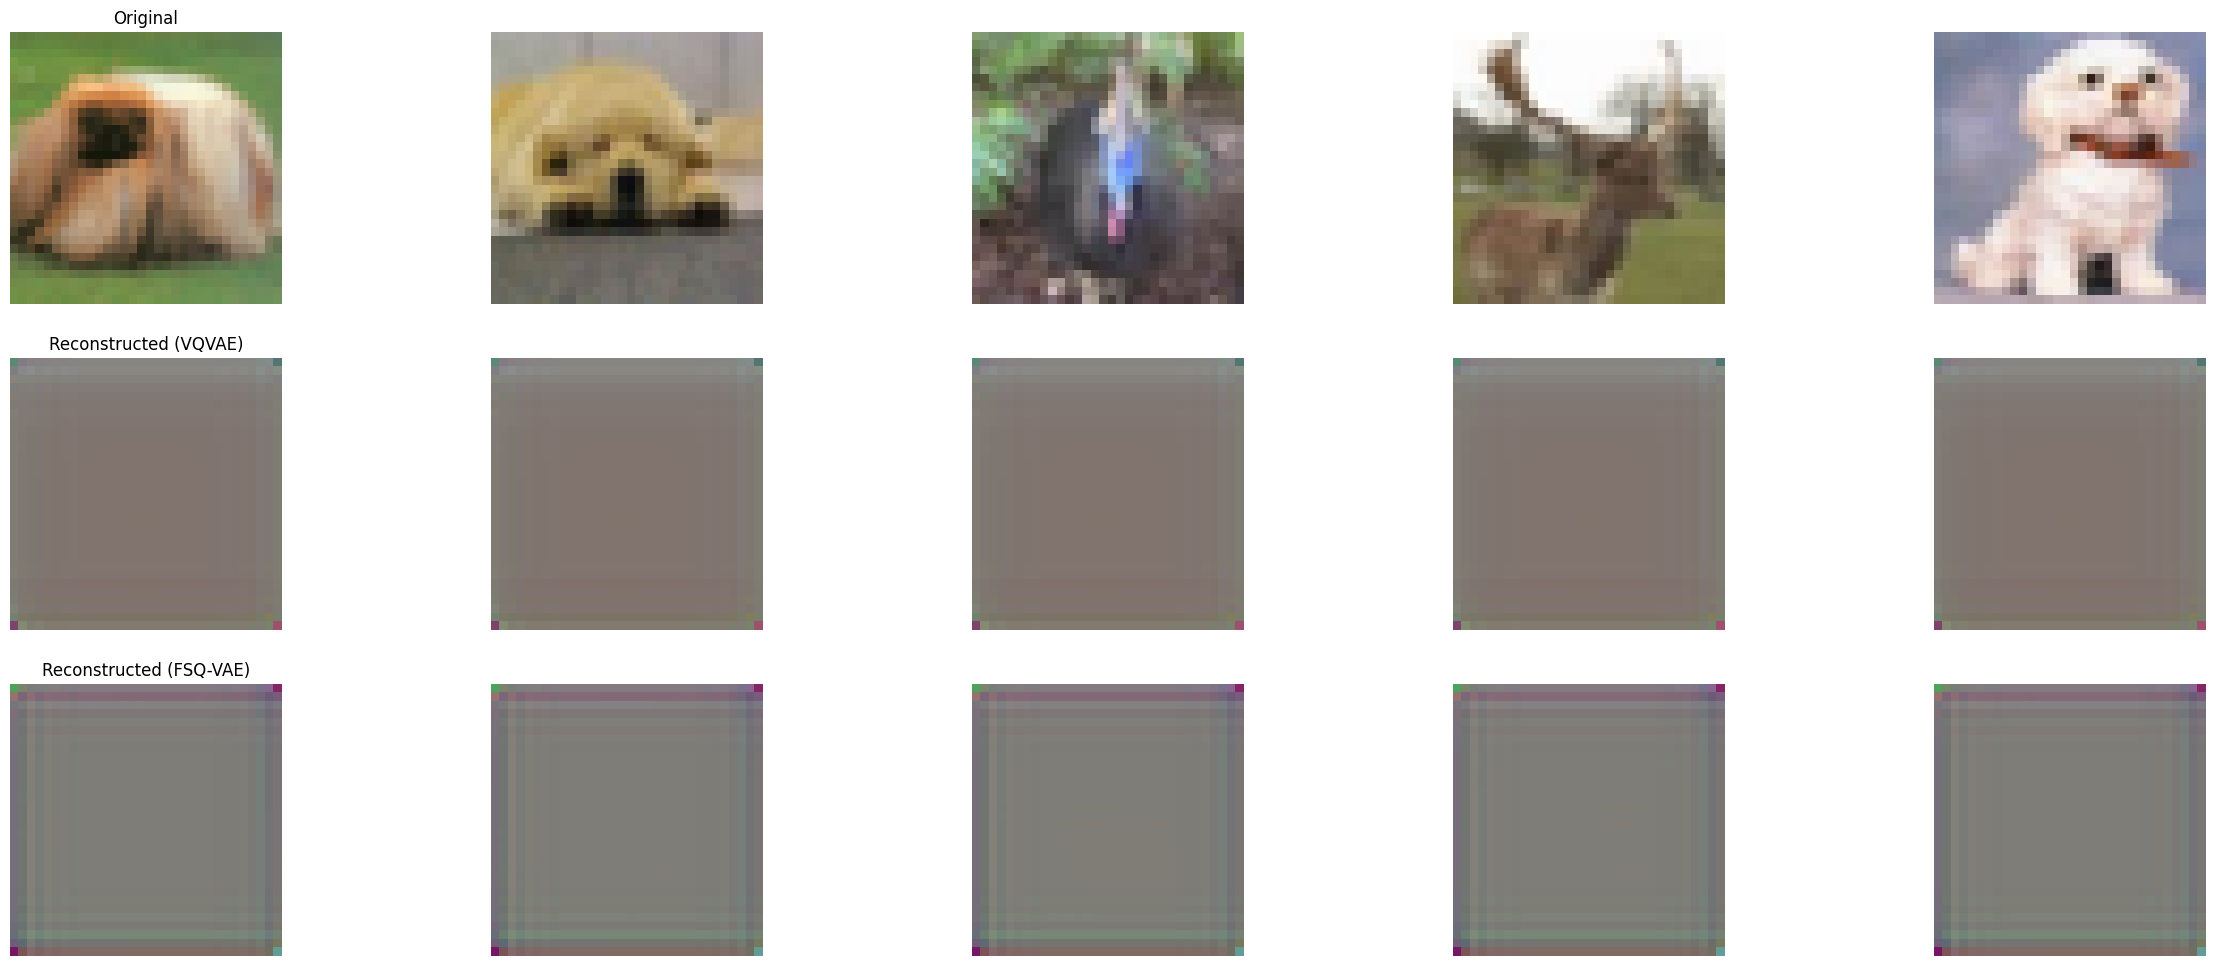

In [ ]:
# Plot some reconstructed images
import matplotlib.pyplot as plt

def plot_reconstructions(models: list[VQVAE], model_names: list[str], images: jax.Array):
    num_images = 5
    fig, axes = plt.subplots(len(models) + 1, num_images, figsize=(num_images * 2 * (len(models) + 1), 4 * (len(models) + 1)))

    # Plot original images in the first row
    for j in range(num_images):
        axes[0, j].imshow(images[j].reshape(32, 32, 3), cmap='gray')
        axes[0, j].axis('off')
        if j == 0:
            axes[0, j].set_title("Original")

    for model_idx, model in enumerate(models):
        reconstructed, _ = model(images)
        for j in range(num_images):
            # Reconstructed image
            axes[model_idx + 1, j].imshow(reconstructed[j].reshape(32, 32, 3), cmap='gray')
            axes[model_idx + 1, j].axis('off')
            if j == 0:
                axes[model_idx + 1, j].set_title(f"Reconstructed ({model_names[model_idx]})")
    plt.show()

sample_batch = next(iter(test_grain_dataset))
plot_reconstructions([vqvae, fsqvae], ["VQVAE", "FSQ-VAE"], sample_batch[:5])

In [ ]:
# Convert whole training dataset to indices and display the first image's indices
from array_record.python import array_record_module as arm
import pickle

def export_to_indices(model: VQVAE, train_data: Dataset, output_file: str, batch_size: int = 32):
    BAR_FORMAT = "{desc}[{n_fmt}/{total_fmt}]{postfix} [{elapsed}<{remaining}]"

    train_label_grain_dataset = grain.MapDataset.source(train_data) \
        .map(lambda x: {
            "img": preprocess(x["img"]),
            "label": x["label"]
        }) \
        .map(lambda x: {
            "img": x["img"],
            "img_indices": model.encode_to_indices(x["img"].reshape(1, 32, 32, 3)),
            "label": x["label"]
        }) \
        .batch(batch_size=batch_size)

    ar_writer = arm.ArrayRecordWriter(output_file, group_size=256)
    record_count = 0


    with tqdm(
        desc=f"Converting training dataset to indices ",
        total=len(train_data),
        bar_format=BAR_FORMAT,
        leave=True,
    ) as pbar:
        for record in train_label_grain_dataset:
            ar_writer.write(pickle.dumps(record))
            record_count += len(record["img"])
            pbar.update(len(record["img"]))

    ar_writer.close()


In [ ]:
export_to_indices(vqvae, train_data, './data/train_vqvae_indices.ar', batch_size=32)

Converting training dataset to indices [1536/50000] [00:29<15:35]


KeyboardInterrupt: 

In [ ]:
export_to_indices(fsqvae, train_data, './data/train_fsqvae_indices.ar', batch_size=32)

Converting training dataset to indices [0/50000] [00:00<?]


ValueError: not enough values to unpack (expected 2, got 1)